# Decision Tree and Random Forest:  Will They Overfit?

In [158]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# Kaggle: Don't Overfit II Dataset

In [136]:
train = pd.read_csv("../data/train.csv").sample(frac=1.0)
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [137]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']
X_test = test.drop(['id'], axis=1)

In [4]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)
#repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)

In [6]:
def get_predictions(x):
    return [1 if xi >= 0.5 else 0 for xi in x]

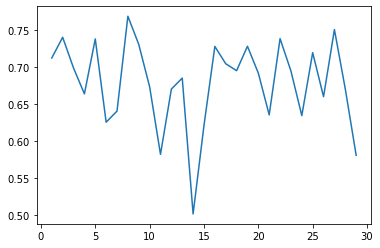

In [97]:
# find Random Forest max depth sequentially 

acc = []
for depth in range(1,30):
    # simple 70/30 train/test split for determining best random forest max depth
    X_train_param, X_test_param, y_train_param, y_test_param = train_test_split(X,y,test_size=0.30)
    
    rfc = RandomForestClassifier(max_depth=depth).fit(X_train_param,y_train_param)
    
    preds = rfc.predict_proba(X_test_param)[:,1]
    auc = roc_auc_score(y_test_param, preds)
    acc.append(auc)
    
plt.plot([x for x in range(1,30)], acc)

In [36]:
max_depth = 8

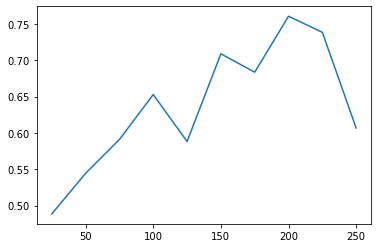

In [93]:
# find Random Forest number of estimators sequentially
n_estimators = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
acc = []
    
for n in n_estimators:
    X_train_param, X_test_param, y_train_param, y_test_param = train_test_split(X,y,test_size=0.30)
    rfc = RandomForestClassifier(max_depth=max_depth, n_estimators=n).fit(X_train_param,y_train_param)
    preds = rfc.predict_proba(X_test_param)[:,1]
    auc = roc_auc_score(y_test_param, preds)
    acc.append(auc)
    
plt.plot(n_estimators, acc)

In [94]:
n_estimators = 200

In [138]:
# grid search for params
rfc = RandomForestClassifier()

parameter_grid = {'max_features': [25, 50, 75, 100, 150, 200],
                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': [25, 50, 75, 100, 150, 200]},
             scoring='roc_auc')

In [139]:
grid_search.best_params_

{'max_depth': 15, 'max_features': 150}

In [140]:
# leave one out training method
loo = LeaveOneOut()
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):

    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train = y[train_index]
    rfc = RandomForestClassifier(**grid_search.best_params_).fit(X_train, y_train)
    preds[test_index] = rfc.predict_proba(X_test)[:,1]

print(f"Random Forest: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Random Forest: 0.5096180555555556
              precision    recall  f1-score   support

         0.0       0.43      0.18      0.25        90
         1.0       0.65      0.87      0.75       160

    accuracy                           0.62       250
   macro avg       0.54      0.52      0.50       250
weighted avg       0.57      0.62      0.57       250



In [100]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [101]:
dtc = DecisionTreeClassifier()

parameter_grid = {'max_features': [25, 50, 75, 100, 150, 200],
                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15]
                 }

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': [25, 50, 75, 100, 150, 200]},
             scoring='roc_auc')

In [102]:
grid_search.best_params_

{'max_depth': 5, 'max_features': 25}

In [103]:
# leave one out training method - cross valiation
loo = LeaveOneOut()
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train = y[train_index]
    dtc = DecisionTreeClassifier(**grid_search.best_params_).fit(X_train, y_train)
    preds[test_index] = dtc.predict_proba(X_test)[:,1]

print(f"Decision Tree AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Decision Tree AUC score: 0.4829513888888889
              precision    recall  f1-score   support

         0.0       0.31      0.27      0.29        90
         1.0       0.62      0.66      0.64       160

    accuracy                           0.52       250
   macro avg       0.46      0.46      0.46       250
weighted avg       0.51      0.52      0.51       250



# Human Activities and Postural Transitions

In [162]:
label_dict = {4:0, 5:1}

X_train = pd.read_csv("../data/HAPT/Train/X_train.txt", header=None, sep=" ")
y_train = pd.read_csv("../data/HAPT/Train/y_train.txt", header=None).rename(columns={0:"label"})
X_train["label"] = y_train.label
X_train = X_train.sample(frac=1.).reset_index(drop=True)

X_test = pd.read_csv("../data/HAPT/Test/X_test.txt", header=None, sep=" ")
y_test = pd.read_csv("../data/HAPT/Test/y_test.txt", header=None).rename(columns={0:"label"})
X_test["label"] = y_test.label 

train_idx = X_train.label.isin([4,5])

# Sitting vs standing
train_idx = X_train.label.isin([4,5])
X_train = X_train[train_idx].reset_index(drop=True)
X_train["label"] = X_train["label"].map(label_dict)

test_idx = X_test.label.isin([4,5])
X_test = X_test[test_idx].reset_index(drop=True)
X_test["label"] = X_test["label"].map(label_dict)
y_test = X_test["label"]

In [163]:
X, y = X_train[[col for col in X_train.columns if col != "label"]].values , X_train.label

In [122]:
# grid search for params
rfc = RandomForestClassifier()

parameter_grid = {'max_features': [25, 50, 75, 100, 150, 200],
                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': [25, 50, 75, 100, 150, 200]},
             scoring='roc_auc')

In [124]:
grid_search.best_params_

{'max_depth': 15, 'max_features': 200}

In [129]:
loo = KFold(n_splits=10)
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    _X_train, _X_test = X[train_index, :], X[test_index,:]
    _y_train = y[train_index].values
    rfc = RandomForestClassifier(**grid_search.best_params_).fit(_X_train, _y_train)
    preds[test_index] = rfc.predict_proba(_X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.831080411261542
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       508
           1       0.74      0.79      0.76       556

    accuracy                           0.74      1064
   macro avg       0.74      0.74      0.74      1064
weighted avg       0.74      0.74      0.74      1064



In [130]:
dtc = DecisionTreeClassifier()

parameter_grid = {'max_features': [25, 50, 75, 100, 150, 200],
                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15]
                 }

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15],
                         'max_features': [25, 50, 75, 100, 150, 200]},
             scoring='roc_auc')

In [131]:
grid_search.best_params_

{'max_depth': 10, 'max_features': 200}

In [132]:
loo = KFold(n_splits=10)
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    _X_train, _X_test = X[train_index, :], X[test_index,:]
    _y_train = y[train_index].values
    dtc = DecisionTreeClassifier(**grid_search.best_params_).fit(_X_train, _y_train)
    preds[test_index] = dtc.predict_proba(_X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.6580981277969751
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       508
           1       0.64      0.67      0.65       556

    accuracy                           0.63      1064
   macro avg       0.63      0.63      0.63      1064
weighted avg       0.63      0.63      0.63      1064



# League of Legends

In [195]:
train = pd.read_csv("../data/league_train.csv").sample(frac=1.0)
test = pd.read_csv("../data/league_test.csv")

f_cols = [col for col in train.columns if col not in ["matchId", "blue_win"]]

mms = MinMaxScaler(feature_range=(0.001, 0.999))
X_train = mms.fit_transform(train[f_cols])
y_train = train["blue_win"].values
X_test = mms.transform(test[f_cols])
y_test = test["blue_win"].values

In [196]:
# grid search for params
dtc = DecisionTreeClassifier()

parameter_grid = {'max_features': [5,6,7,8,9,10],
                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
                 }

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [197]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 7}

In [198]:
dtc = DecisionTreeClassifier(**grid_search.best_params_).fit(X_train,y_train)
preds = dtc.predict_proba(X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y_test, preds)}")
print(classification_report(y_test, get_predictions(preds)))

Models AUC score: 0.7880483949269166
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     23937
           1       0.71      0.78      0.75     24464

    accuracy                           0.73     48401
   macro avg       0.73      0.73      0.73     48401
weighted avg       0.73      0.73      0.73     48401



In [199]:
# grid search for params
rfc = RandomForestClassifier()

parameter_grid = {'max_features': [5,6,7,8,9,10],
                  'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [201]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 6}

In [200]:
rfc = RandomForestClassifier(**grid_search.best_params_).fit(X_train,y_train)
preds = rfc.predict_proba(X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y_test, preds)}")
print(classification_report(y_test, get_predictions(preds)))

Models AUC score: 0.8496297485704312
              precision    recall  f1-score   support

           0       0.77      0.72      0.75     23937
           1       0.74      0.80      0.77     24464

    accuracy                           0.76     48401
   macro avg       0.76      0.76      0.76     48401
weighted avg       0.76      0.76      0.76     48401

